Importacion de librerias

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                             r2_score, mean_absolute_percentage_error)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("=" * 80)
print("MODELO DE REGRESIÓN LINEAL - PREDICCIÓN DE PRECIOS DE AGUACATE")
print("=" * 80)
print(f"Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)


MODELO DE REGRESIÓN LINEAL - PREDICCIÓN DE PRECIOS DE AGUACATE
Fecha de ejecución: 2025-10-21 21:48:29


Carga y exploración inicial de datos

In [16]:
print("\n[1] CARGANDO DATOS PREPROCESADOS...")
print("-" * 80)

df = pd.read_csv('../../data/processed/avocado_cleaned_normalized.csv')

print(f"✓ Datos cargados exitosamente")
print(f"  - Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"  - Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n[2] INFORMACIÓN DEL DATASET")
print("-" * 80)
print(df.info())

print("\n[3] ESTADÍSTICAS DESCRIPTIVAS")
print("-" * 80)
print(df.describe())


[1] CARGANDO DATOS PREPROCESADOS...
--------------------------------------------------------------------------------
✓ Datos cargados exitosamente
  - Dimensiones: 6725 filas × 66 columnas
  - Memoria utilizada: 1.05 MB

[2] INFORMACIÓN DEL DATASET
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6725 entries, 0 to 6724
Data columns (total 66 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  6725 non-null   float64
 1   AveragePrice                6725 non-null   float64
 2   Total Volume                6725 non-null   float64
 3   4046                        6725 non-null   float64
 4   4225                        6725 non-null   float64
 5   4770                        6725 non-null   float64
 6   Total Bags                  6725 non-null   float64
 7   Small Bags                  6725 non-null   

Preparación de datos para regresion lineal

In [17]:
print("\n[4] PREPARACIÓN DE VARIABLES")
print("-" * 80)

target = 'AveragePrice'
print(f"Variable objetivo: {target}")

features_to_exclude = [target, 'Date'] if 'Date' in df.columns else [target]
feature_columns = [col for col in df.columns if col not in features_to_exclude]

print(f"\nFeatures seleccionadas ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

X = df[feature_columns]
y = df[target]

print(f"\n✓ Datos preparados:")
print(f"  - X shape: {X.shape}")
print(f"  - y shape: {y.shape}")


[4] PREPARACIÓN DE VARIABLES
--------------------------------------------------------------------------------
Variable objetivo: AveragePrice

Features seleccionadas (65):
  1. Unnamed: 0
  2. Total Volume
  3. 4046
  4. 4225
  5. 4770
  6. Total Bags
  7. Small Bags
  8. Large Bags
  9. XLarge Bags
  10. year
  11. month
  12. day
  13. day_of_week
  14. type_organic
  15. region_Atlanta
  16. region_BaltimoreWashington
  17. region_Boise
  18. region_Boston
  19. region_BuffaloRochester
  20. region_California
  21. region_Charlotte
  22. region_Chicago
  23. region_CincinnatiDayton
  24. region_Columbus
  25. region_DallasFtWorth
  26. region_Denver
  27. region_Detroit
  28. region_GrandRapids
  29. region_GreatLakes
  30. region_HarrisburgScranton
  31. region_HartfordSpringfield
  32. region_Houston
  33. region_Indianapolis
  34. region_Jacksonville
  35. region_LasVegas
  36. region_LosAngeles
  37. region_Louisville
  38. region_MiamiFtLauderdale
  39. region_Nashville
  40. 

Análisis de correlación


[5] ANÁLISIS DE CORRELACIÓN
--------------------------------------------------------------------------------

Top 10 variables más correlacionadas con AveragePrice:
region_HartfordSpringfield    0.259788
type_organic                  0.183622
month                         0.153882
region_Sacramento             0.138254
region_NewYork                0.137342
region_SanFrancisco           0.129823
region_Philadelphia           0.114198
region_Charlotte              0.100860
4770                          0.084749
region_RaleighGreensboro      0.076100
Name: AveragePrice, dtype: float64

✓ Matriz de correlación guardada


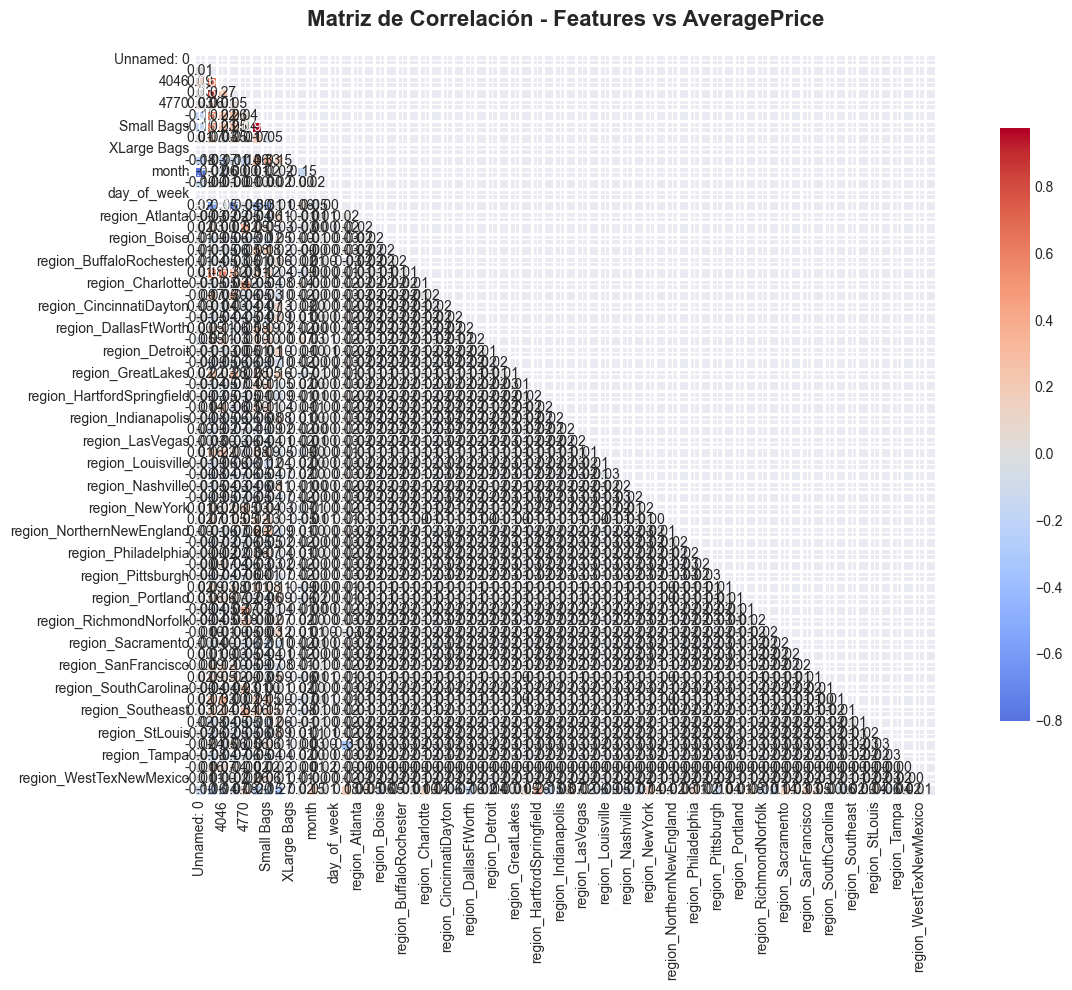

In [18]:
print("\n[5] ANÁLISIS DE CORRELACIÓN")
print("-" * 80)

correlation = df[feature_columns + [target]].corr()[target].sort_values(ascending=False)
print("\nTop 10 variables más correlacionadas con AveragePrice:")
print(correlation.head(11)[1:])  # Excluir la correlación consigo misma

plt.figure(figsize=(14, 10))
correlation_matrix = df[feature_columns + [target]].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Features vs AveragePrice', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../../results/plots/linear_regression_correlation_matrix.png', dpi=300, bbox_inches='tight')
print("\n✓ Matriz de correlación guardada")
plt.show()

División de datos (train/test)

In [19]:
print("\n[6] DIVISIÓN DE DATOS")
print("-" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"✓ División completada:")
print(f"  - Conjunto de entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Conjunto de prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\n  Estadísticas de la variable objetivo:")
print(f"  - Train: Media={y_train.mean():.3f}, Std={y_train.std():.3f}")
print(f"  - Test:  Media={y_test.mean():.3f}, Std={y_test.std():.3f}")



[6] DIVISIÓN DE DATOS
--------------------------------------------------------------------------------
✓ División completada:
  - Conjunto de entrenamiento: 5380 muestras (80.0%)
  - Conjunto de prueba: 1345 muestras (20.0%)

  Estadísticas de la variable objetivo:
  - Train: Media=0.535, Std=0.175
  - Test:  Media=0.534, Std=0.171


Normalizción de datos

In [20]:
print("\n[7] NORMALIZACIÓN DE FEATURES")
print("-" * 80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Normalización aplicada (StandardScaler)")
print(f"  - Media features normalizadas: {X_train_scaled.mean():.2e}")
print(f"  - Desviación estándar: {X_train_scaled.std():.2e}")



[7] NORMALIZACIÓN DE FEATURES
--------------------------------------------------------------------------------
✓ Normalización aplicada (StandardScaler)
  - Media features normalizadas: -6.46e-18
  - Desviación estándar: 9.84e-01


Entrenamiento de modelo

In [21]:
print("\n[8] ENTRENAMIENTO DEL MODELO DE REGRESIÓN LINEAL")
print("-" * 80)

model = LinearRegression()
print("Entrenando modelo...")
model.fit(X_train_scaled, y_train)
print("✓ Modelo entrenado exitosamente")

print(f"\n  Parámetros del modelo:")
print(f"  - Número de coeficientes: {len(model.coef_)}")
print(f"  - Intercepto: {model.intercept_:.4f}")



[8] ENTRENAMIENTO DEL MODELO DE REGRESIÓN LINEAL
--------------------------------------------------------------------------------
Entrenando modelo...
✓ Modelo entrenado exitosamente

  Parámetros del modelo:
  - Número de coeficientes: 65
  - Intercepto: 0.5348


Predicciones

In [22]:
print("\n[9] GENERANDO PREDICCIONES")
print("-" * 80)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print("✓ Predicciones generadas")
print(f"  - Predicciones train: {len(y_train_pred)}")
print(f"  - Predicciones test: {len(y_test_pred)}")



[9] GENERANDO PREDICCIONES
--------------------------------------------------------------------------------
✓ Predicciones generadas
  - Predicciones train: 5380
  - Predicciones test: 1345


Evaluación del modelo

In [23]:
print("\n[10] EVALUACIÓN DEL MODELO")
print("=" * 80)

def calculate_metrics(y_true, y_pred, dataset_name):
    """Calcula y muestra métricas de evaluación"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    print(f"\n{dataset_name}:")
    print(f"  - R² Score:                {r2:.6f}")
    print(f"  - Mean Squared Error (MSE): {mse:.6f}")
    print(f"  - Root Mean Squared Error:  {rmse:.6f}")
    print(f"  - Mean Absolute Error:      {mae:.6f}")
    print(f"  - MAPE:                     {mape:.4f}%")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

train_metrics = calculate_metrics(y_train, y_train_pred, "CONJUNTO DE ENTRENAMIENTO")
test_metrics = calculate_metrics(y_test, y_test_pred, "CONJUNTO DE PRUEBA")

print("\n[11] VALIDACIÓN CRUZADA (K-FOLD = 5)")
print("-" * 80)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, 
                            scoring='r2', n_jobs=-1)
print(f"✓ R² Scores por fold: {cv_scores}")
print(f"  - Media: {cv_scores.mean():.6f}")
print(f"  - Desviación estándar: {cv_scores.std():.6f}")



[10] EVALUACIÓN DEL MODELO

CONJUNTO DE ENTRENAMIENTO:
  - R² Score:                0.470147
  - Mean Squared Error (MSE): 0.016238
  - Root Mean Squared Error:  0.127427
  - Mean Absolute Error:      0.099928
  - MAPE:                     31325871382582.3242%

CONJUNTO DE PRUEBA:
  - R² Score:                0.482470
  - Mean Squared Error (MSE): 0.015175
  - Root Mean Squared Error:  0.123187
  - Mean Absolute Error:      0.096965
  - MAPE:                     23.7443%

[11] VALIDACIÓN CRUZADA (K-FOLD = 5)
--------------------------------------------------------------------------------
✓ R² Scores por fold: [0.43038727 0.4387363  0.430734   0.47801802 0.47141027]
  - Media: 0.449857
  - Desviación estándar: 0.020620


Análisis de coeficientes


[12] ANÁLISIS DE COEFICIENTES (IMPORTANCIA DE FEATURES)

Top 10 Features más importantes:
                   Feature  Coefficient  Abs_Coefficient
                Total Bags   585.222362       585.222362
                Small Bags  -577.538256       577.538256
                Large Bags  -127.003718       127.003718
              Total Volume     0.495033         0.495033
                      4225    -0.367023         0.367023
                      4046    -0.234674         0.234674
                     month     0.056880         0.056880
                      year     0.052932         0.052932
region_HartfordSpringfield     0.046004         0.046004
         region_California     0.044687         0.044687

✓ Gráfico de importancia guardado


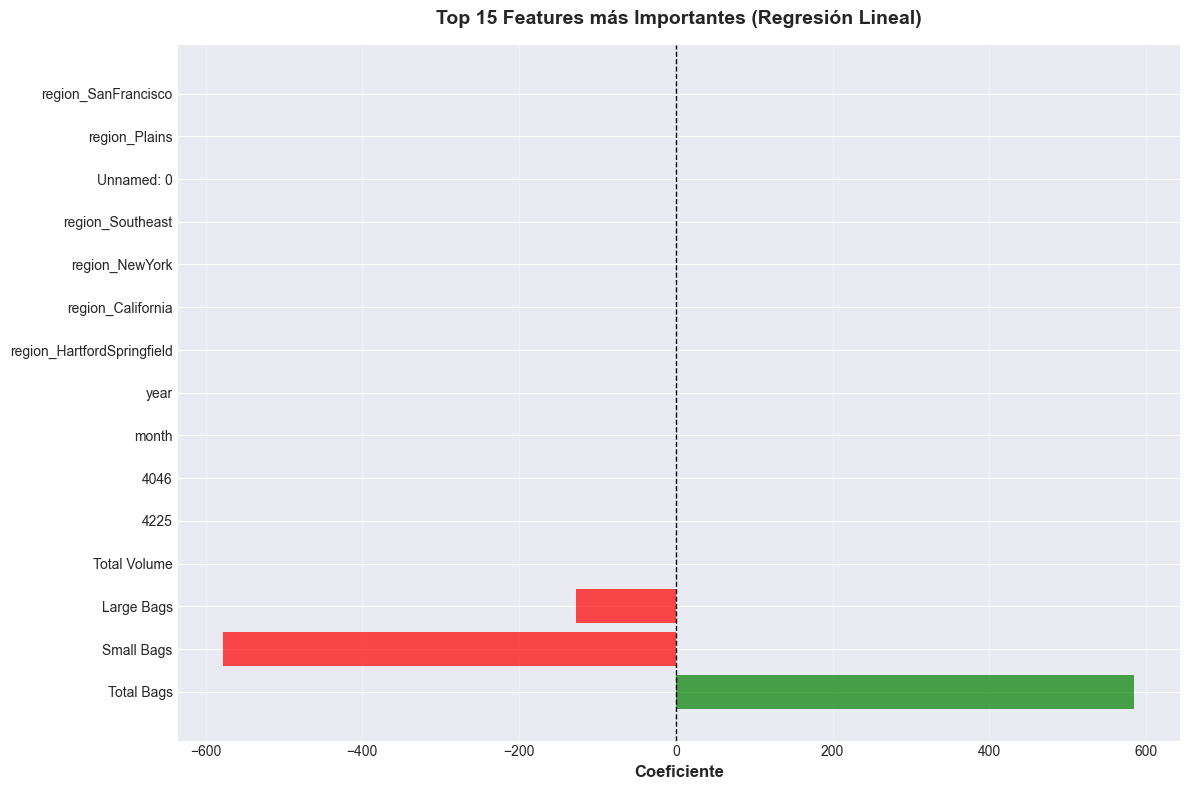

In [24]:
print("\n[12] ANÁLISIS DE COEFICIENTES (IMPORTANCIA DE FEATURES)")
print("=" * 80)

coefficients = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 Features más importantes:")
print(coefficients.head(10).to_string(index=False))

plt.figure(figsize=(12, 8))
top_n = 15
top_coef = coefficients.head(top_n)
colors = ['green' if x > 0 else 'red' for x in top_coef['Coefficient']]
plt.barh(range(len(top_coef)), top_coef['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_coef)), top_coef['Feature'])
plt.xlabel('Coeficiente', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Features más Importantes (Regresión Lineal)', 
          fontsize=14, fontweight='bold', pad=15)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../../results/plots/linear_regression_feature_importance.png', dpi=300, bbox_inches='tight')
print("\n✓ Gráfico de importancia guardado")
plt.show()

Visualización de resultados


[13] GENERANDO VISUALIZACIONES
--------------------------------------------------------------------------------
✓ Visualizaciones guardadas


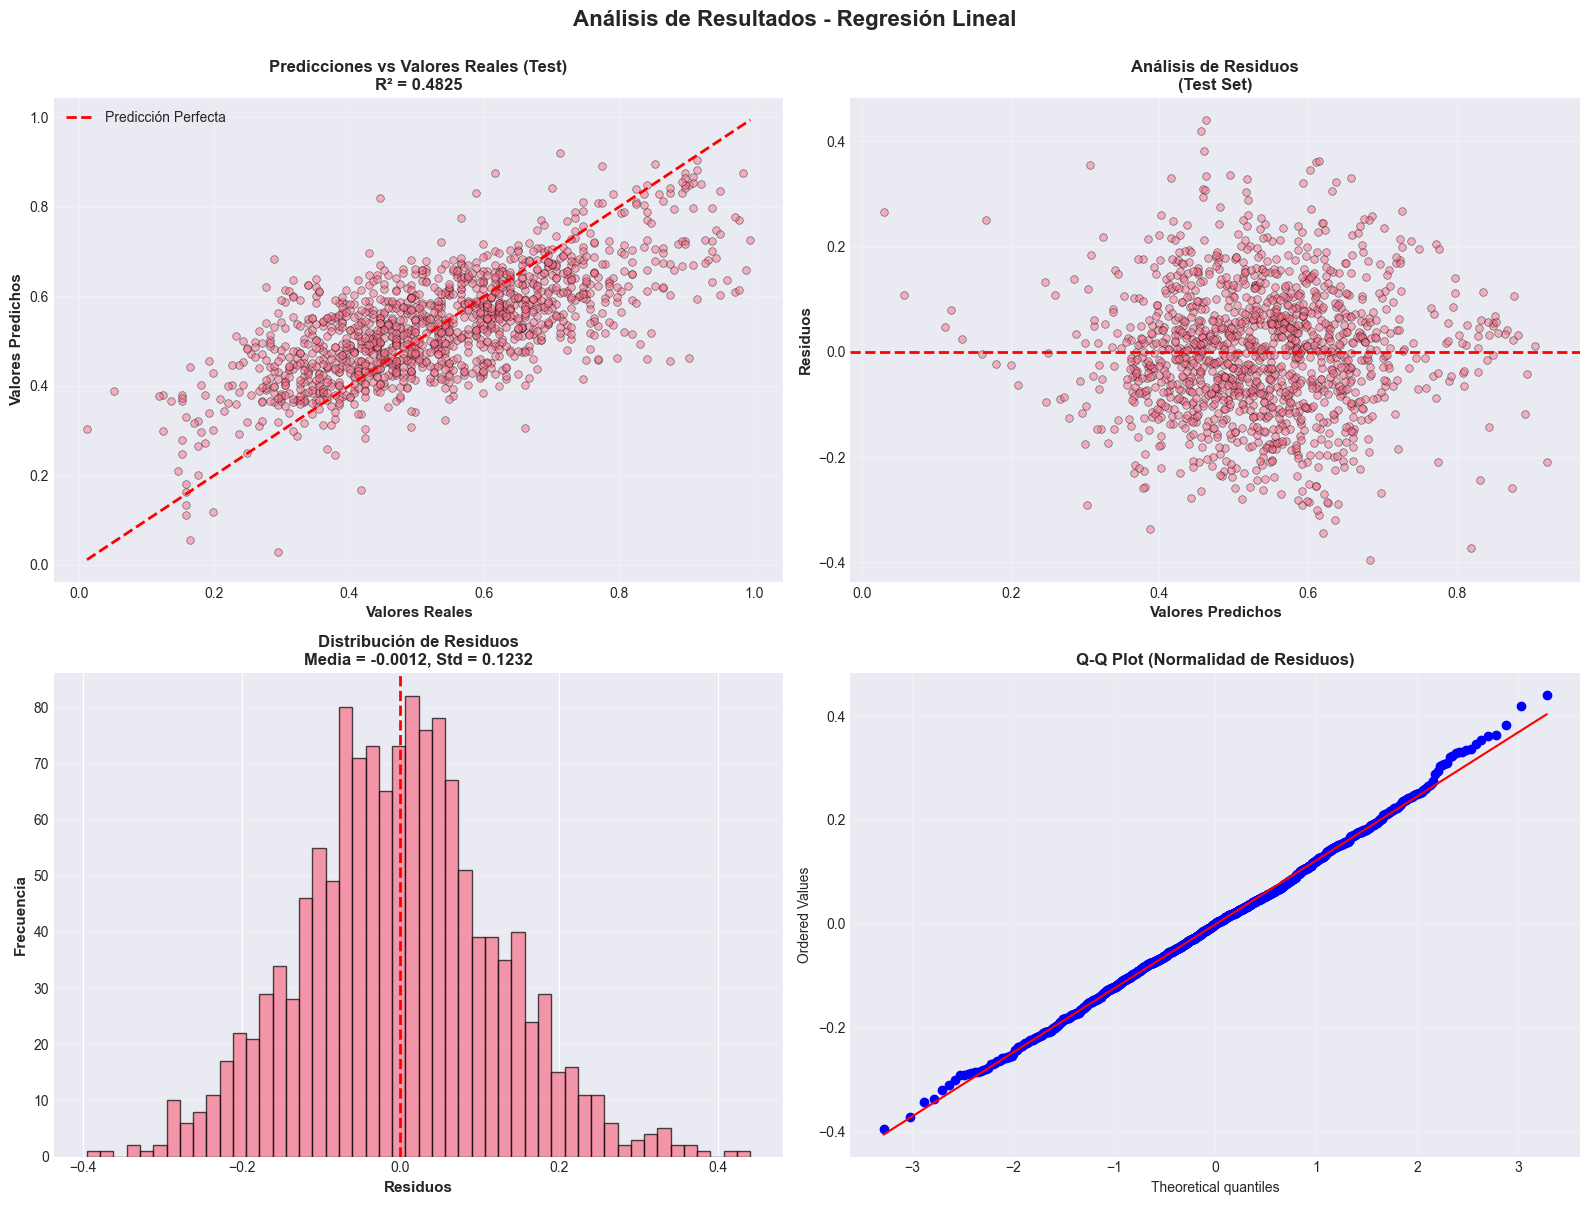

In [25]:
print("\n[13] GENERANDO VISUALIZACIONES")
print("-" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis de Resultados - Regresión Lineal', 
             fontsize=16, fontweight='bold', y=1.00)

# 1. Valores Reales vs Predicciones (Test)
ax1 = axes[0, 0]
ax1.scatter(y_test, y_test_pred, alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Predicción Perfecta')
ax1.set_xlabel('Valores Reales', fontsize=11, fontweight='bold')
ax1.set_ylabel('Valores Predichos', fontsize=11, fontweight='bold')
ax1.set_title(f'Predicciones vs Valores Reales (Test)\nR² = {test_metrics["R2"]:.4f}', 
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Residuos
ax2 = axes[0, 1]
residuals = y_test - y_test_pred
ax2.scatter(y_test_pred, residuals, alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Valores Predichos', fontsize=11, fontweight='bold')
ax2.set_ylabel('Residuos', fontsize=11, fontweight='bold')
ax2.set_title('Análisis de Residuos\n(Test Set)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Distribución de Residuos
ax3 = axes[1, 0]
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax3.set_xlabel('Residuos', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax3.set_title(f'Distribución de Residuos\nMedia = {residuals.mean():.4f}, Std = {residuals.std():.4f}', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Q-Q Plot
ax4 = axes[1, 1]
from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot (Normalidad de Residuos)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/plots/linear_regression_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Visualizaciones guardadas")
plt.show()

Curva de aprendizaje


[14] CURVA DE APRENDIZAJE
--------------------------------------------------------------------------------
✓ Curva de aprendizaje guardada


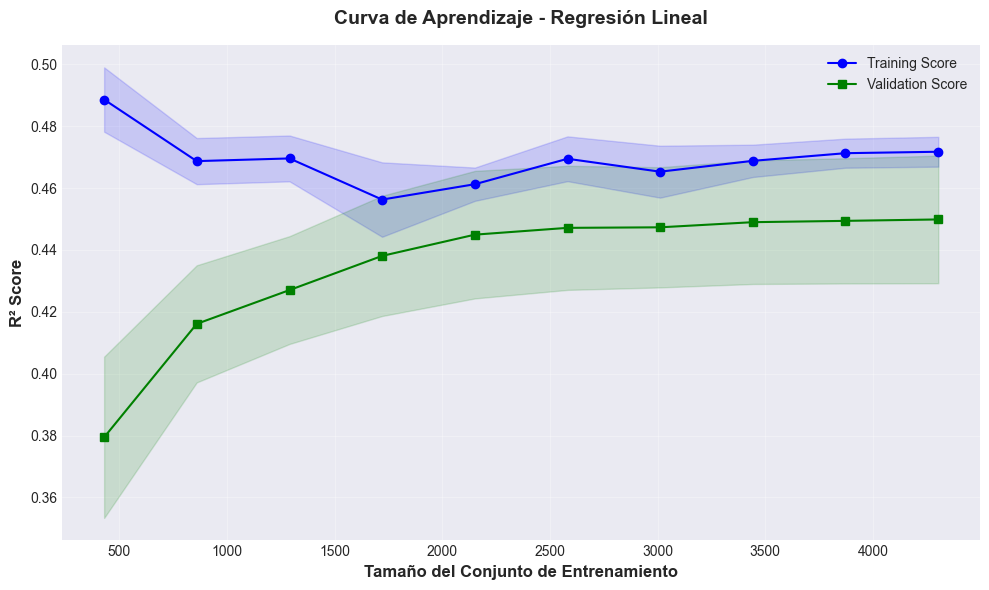

In [26]:
print("\n[14] CURVA DE APRENDIZAJE")
print("-" * 80)

train_sizes, train_scores, val_scores = learning_curve(
    model, X_train_scaled, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='r2'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, label='Validation Score', color='green', marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color='green')
plt.xlabel('Tamaño del Conjunto de Entrenamiento', fontsize=12, fontweight='bold')
plt.ylabel('R² Score', fontsize=12, fontweight='bold')
plt.title('Curva de Aprendizaje - Regresión Lineal', fontsize=14, fontweight='bold', pad=15)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../../results/plots/linear_regression_learning_curve.png', dpi=300, bbox_inches='tight')
print("✓ Curva de aprendizaje guardada")
plt.show()